# Intro

7/26: The purpose of this notebook is to double check that we're calculating the surface terms correctly when we look at advective and diffusive tendencies. This will look at map view and TS view of the Barents Sea at the surface in one month (March) to see if we're doing this thing correctly.

# Load the files, set up grid

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

import warnings
warnings.filterwarnings("ignore")


# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh
from plotting_helpers import *           # truncate_colormap

In [2]:
%run /home/mmurakami/crios_backups/ASTE_270/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
RAC3d = np.tile(RAC[np.newaxis,:,:],(nz,1,1))
RAC3d.shape

(50, 1350, 270)

In [4]:
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [5]:
klev = 0

In [6]:

# read one basin or whole ASTE
whole = False
if not whole:
    iB = 6    # example read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
if whole:
    mask = (mymsk < 5) | (mymsk==6) 
else:
    mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


In [7]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

m = 0
s = 2

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
# times["2014"] = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
times["2014"] = np.array([3,4])     # tend will be calculated from tsteps before and after one month

# try a different month to see
# times["2014"] = np.array([9,10])     # tend will be calculated from tsteps before and after one month


# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

### note -- these are thetadr and saltdr but are called theta and salt, dthetadt and dsaltdt

In [77]:
tsstr

array(['0000639648', '0000644112'], dtype='<U32')

In [80]:
# note: the following works provided that the first 3 terms are definitely there
file_name = "state_3d_set1"
meta_budg2d_zflux_set2 = parsemeta(dirState + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirState, file_name),int(tsstr[1]),returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirState, file_name),int(tsstr[1]),returnmeta=True,rec=recs[1])

In [85]:
THETA = THETA.reshape(nz,ny,nx)
SALT = SALT.reshape(nz,ny,nx)

In [86]:
# note: the following works provided that the first 3 terms are definitely there
file_name = "state_2d_set1"
meta_budg2d_zflux_set2 = parsemeta(dirState + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["SIheff","SIarea"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
SIheff,its,meta = rdmds(os.path.join(dirState, file_name),int(tsstr[1]),returnmeta=True,rec=recs[0])
SIarea,its,meta = rdmds(os.path.join(dirState, file_name),int(tsstr[1]),returnmeta=True,rec=recs[1])

SIheff = SIheff.reshape(ny,nx)
SIarea = SIarea.reshape(ny,nx)

In [102]:
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[1] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceQnet","WTHMASS","SIaaflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceQnet,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[1]),returnmeta=True,rec=recs[0])
WTHMASS,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[1]),returnmeta=True,rec=recs[1])
SIaaflux,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[1]),returnmeta=True,rec=recs[2])

In [104]:
oceQnet = oceQnet.reshape((ny,nx))
WTHMASS = WTHMASS.reshape((ny,nx))
SIaaflux = SIaaflux.reshape((ny,nx))

In [8]:
file_name = 'budg3d_snap_set2'
THETADR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["THETADR"]),mymsk,dirIn)
SALTDR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["SALTDR"]),mymsk,dirIn)

# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

thetadr = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadrdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
saltdr = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdrdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    # with dividing out hFacC grid
    theta[i,:,:,:] = THETADR[i,:,:,:]/mygrid['hFacC']/DRF3d
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/mygrid['hFacC']/DRF3d

    # without dividing out hFacC grid
    thetadr[i,:,:,:] = THETADR[i,:,:,:]  #/mygrid['hFacC']
    saltdr[i,:,:,:]  = SALTDR[i,:,:,:]  #/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

    # keeping the weights in the function
    dthetadrdt[i,:,:,:] = (THETADR[i,:,:,:] - THETADR[i-1,:,:,:])/dt[i-1]
    dsaltdrdt[i,:,:,:] = (SALTDR[i,:,:,:] - SALTDR[i-1,:,:,:])/dt[i-1]

In [9]:
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    ETAN = np.reshape(ETAN,(ny,nx))

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))

print(vol.shape)

volume allocation shape (2, 50, 1350, 270)
(2, 50, 1350, 270)


In [10]:
# first have to get the vector values from U and V
file_name = "budg3d_hflux_set2"
# UVELMASS = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['UVELMASS']),mymsk,dirIn)
# VVELMASS = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['VVELMASS']),mymsk,dirIn)
ADVx_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVx_TH']),mymsk,dirIn)     # degC m^3/s
ADVy_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVy_TH']),mymsk,dirIn)
DFxE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFxE_TH']),mymsk,dirIn)
DFyE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFyE_TH']),mymsk,dirIn)
ADVx_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVx_SLT']),mymsk,dirIn)   # PSU m^3/s
ADVy_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVy_SLT']),mymsk,dirIn)
DFxE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFxE_SLT']),mymsk,dirIn)
DFyE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFyE_SLT']),mymsk,dirIn)

In [11]:
file_name = "budg3d_zflux_set2"
ADVr_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVr_SLT']),mymsk,dirIn)
ADVr_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVr_TH']),mymsk,dirIn)
DFrE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFrE_SLT']),mymsk,dirIn)
DFrE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFrE_TH']),mymsk,dirIn)
DFrI_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFrI_SLT']),mymsk,dirIn)
DFrI_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFrI_TH']),mymsk,dirIn)

In [12]:
file_name = "budg3d_kpptend_set1"
KPPg_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['KPPg_TH']),mymsk,dirIn)
KPPg_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['KPPg_SLT']),mymsk,dirIn)
oceSPtnd = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['oceSPtnd']),mymsk,dirIn)

In [13]:
# first have to get the vector values from U and V
# get the vectors of u and v without mass weighting
ADVx_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVy_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFxE_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFyE_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVx_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVy_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFxE_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFyE_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)

for i in range((int(len(tsstr)))):
    # get values from reading before
    tmpUadvth = ADVx_TH[i]
    tmpVadvth = ADVy_TH[i]
    tmpUdfth = DFxE_TH[i]
    tmpVdfth = DFyE_TH[i]
    tmpUadvslt = ADVx_SLT[i]
    tmpVadvslt = ADVy_SLT[i]
    tmpUdfslt = DFxE_SLT[i]
    tmpVdfslt = DFyE_SLT[i]

    # define u and v velocities
    # define in theta
    tmpUadvth,tmpVadvth = get_aste_vector_face1_3(tmpUadvth,tmpVadvth,nfx,nfy,False)
    tmpUadvth,tmpVadvth = tmpUadvth[:,:-1,:-1],tmpVadvth[:,:-1,:-1]     # centering
    tmpUdfth,tmpVdfth = get_aste_vector_face1_3(tmpUdfth,tmpVdfth,nfx,nfy,False)
    tmpUdfth,tmpVdfth = tmpUdfth[:,:-1,:-1],tmpVdfth[:,:-1,:-1]     # centering
    # define in salt
    tmpUadvslt,tmpVadvslt = get_aste_vector_face1_3(tmpUadvslt,tmpVadvslt,nfx,nfy,False)
    tmpUadvslt,tmpVadvslt = tmpUadvslt[:,:-1,:-1],tmpVadvslt[:,:-1,:-1]     # centering
    tmpUdfslt,tmpVdfslt = get_aste_vector_face1_3(tmpUdfslt,tmpVdfslt,nfx,nfy,False)
    tmpUdfslt,tmpVdfslt = tmpUdfslt[:,:-1,:-1],tmpVdfslt[:,:-1,:-1]     # centering

    # add to larger arrays
    ADVx_THo[i] = tmpUadvth
    ADVy_THo[i] = tmpVadvth
    DFxE_THo[i] = tmpUdfth
    DFyE_THo[i] = tmpVdfth
    ADVx_SLTo[i] = tmpUadvslt
    ADVy_SLTo[i] = tmpVadvslt
    DFxE_SLTo[i] = tmpUdfslt
    DFyE_SLTo[i] = tmpVdfslt

In [97]:
# load the surface heat - to transform we / by rcp [J/(m^3*degC)] and * by RAC [m^2] = degC.m^3/s
file_name = 'budg2d_zflux_set1'
TFLUX = read_field2d(tsstr,ny,nx,file_name,np.array(['TFLUX']),mymsk,dirIn)            # W/m^2
SItflux = read_field2d(tsstr,ny,nx,file_name,np.array(['SItflux']),mymsk,dirIn)        # W/m^2
oceQsw = read_field2d(tsstr,ny,nx,file_name,np.array(['oceQsw']),mymsk,dirIn)          # W/m^2
SPforcT1=0*np.ones((ny,nx))
TRELAX = np.zeros((ny,nx))
geothFlux = 0

# load the surface terms for salt - to transform we / by rho [m^3/s] and * by RAC [m^2] = PSU.m^3/s
file_name = 'budg2d_zflux_set1'
SFLUX = read_field2d(tsstr,ny,nx,file_name,np.array(['SFLUX']),mymsk,dirIn)            # g/m^2/s
oceSPflx = read_field2d(tsstr,ny,nx,file_name,np.array(['oceSPflx']),mymsk,dirIn)      # g/m^2/s
file_name = 'budg2d_zflux_set2'
oceSflux = read_field2d(tsstr,ny,nx,file_name,np.array(['oceSflux']),mymsk,dirIn)      # g/m^2/s 
WSLTMASS = read_field2d(tsstr,ny,nx,file_name,np.array(['WSLTMASS']),mymsk,dirIn)      # PSU.m/s

In [ ]:
TFLUX = TFLUX[1]
SItflux

# Create the TS bins

In [15]:
# try new T bins where different sizes
refined_section = np.linspace(-3,8,93)
coarse_section = np.linspace(8,15,21,endpoint=False)
binsTH_edges = np.concatenate((refined_section,coarse_section[1:]))
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

# do bi-sectional form for S
coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)


# create the binned values for theta and salt
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(theta,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salt,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [16]:
# maskArc = mskBasin * mymsk

# binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
# binwidthsT_tile = np.tile(binwidthT, (112, 1))

# idxs = np.where(maskArc == iB)
# npoints = len(idxs[0])
# mesh = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity, binned_theta,vol,idxs,dT,dS)
# print(mesh.shape)



maskArc = mskBasin * mymsk

binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

idxs = np.where(maskArc == iB)
npoints = len(idxs[0])

# create the mesh for just the surface volume
# do surface distribution if needed
surf_vol = vol.copy()
surf_vol[:,:klev,:,:] = np.nan
surf_vol[:,klev+1:,:,:] = np.nan

In [17]:
# plt.pcolormesh(get_aste_tracer(surf_vol[1],nfx,nfy)[0])
# plt.pcolormesh(get_aste_tracer(binned_salinity[1][0],nfx,nfy)[0])
# plt.colorbar()
# plt.xlim(420,540)
# plt.ylim(400,600)

In [18]:
mesh = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity, binned_theta,surf_vol,idxs,dT,dS)

In [19]:
# # create the surface volume distribution for one month
mydata_test_m1 = np.nansum(mesh[1],axis=2)   # sum of volume for April snap -- represents March
# plt.pcolormesh(mydata_test_m1)
# plt.colorbar()

# create some sample plots of the surface layer of advection

Text(0.5, 1.0, 'ADV y SLT')

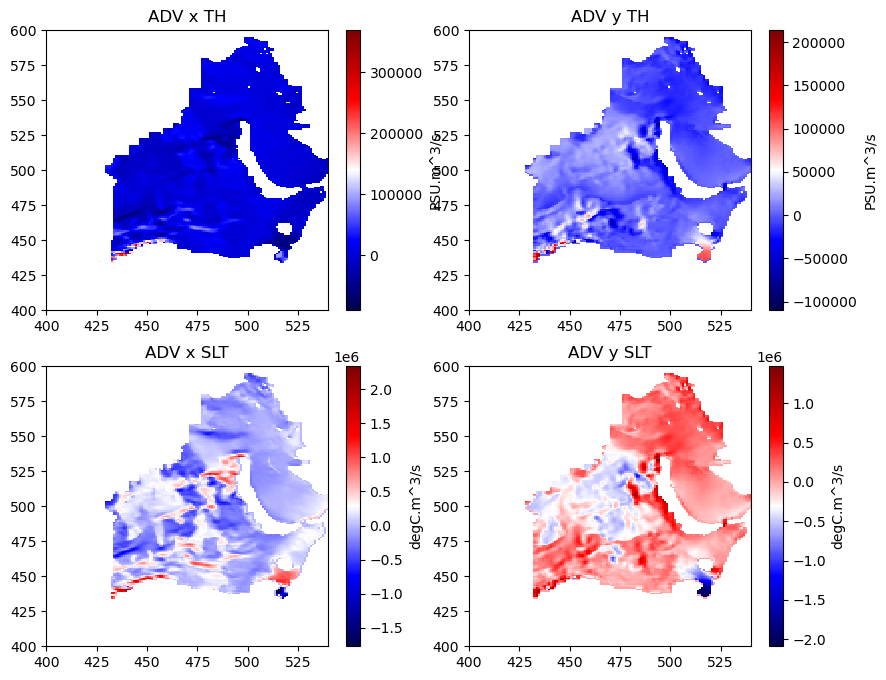

In [20]:
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(221)
cb = ax.pcolormesh((ADVx_THo[1][klev]),cmap='seismic')#,vmin=-50,vmax=50)
plt.colorbar(cb,label="PSU.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("ADV x TH")

ax = plt.subplot(222)
cb = ax.pcolormesh((ADVy_THo[1][klev]),cmap='seismic')#,vmin=-50,vmax=50)
plt.colorbar(cb,label="PSU.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("ADV y TH")

# ax = plt.subplot(233)
# cb = ax.pcolormesh(get_aste_tracer(ADVr_TH[1],nfx,nfy)[0],cmap='seismic')
# # plt.colorbar(cb)
# ax.set_xlim(400,540)
# ax.set_ylim(400,600)

ax = plt.subplot(223)
cb = ax.pcolormesh((ADVx_SLTo[1][klev]),cmap='seismic')#,vmin=-500,vmax=500)   # funny estimate for dividing by binwidths
plt.colorbar(cb,label="degC.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("ADV x SLT")

ax = plt.subplot(224)
cb = ax.pcolormesh((ADVy_SLTo[1][klev]),cmap='seismic')#,vmin=-500,vmax=500)
plt.colorbar(cb,label="degC.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("ADV y SLT")

# plt.savefig(path + "ADVterms_mapview.png",dpi=300)

Text(0.5, 0.98, 'BarentsS 2014-03 Surface Conditions')

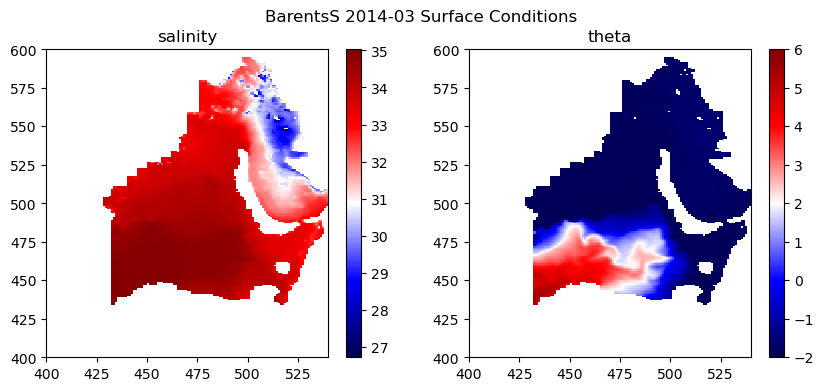

In [21]:
fig = plt.figure(figsize=(10,4))

ax = plt.subplot(121)
surfsalt = saltdr[1] / DRF3d * mygrid['hFacC']
cb = ax.pcolormesh(get_aste_tracer(surfsalt,nfx,nfy)[klev],cmap='seismic')
plt.colorbar(cb)
ax.set_title("salinity")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(122)
surftemp = thetadr[1] / DRF3d * mygrid['hFacC']
cb = ax.pcolormesh(get_aste_tracer(surftemp,nfx,nfy)[klev],cmap='seismic',vmin=-2,vmax=6)
plt.colorbar(cb)
ax.set_title("theta")
ax.set_xlim(400,540)
ax.set_ylim(400,600)

plt.suptitle("BarentsS 2014-03 Surface Conditions")
# plt.savefig(path + "BarentsS_surfconditions.png",dpi=300)

Text(0.5, 1.0, 'ADVx_SLT + ADVy_SLT  + ADVr_SLT')

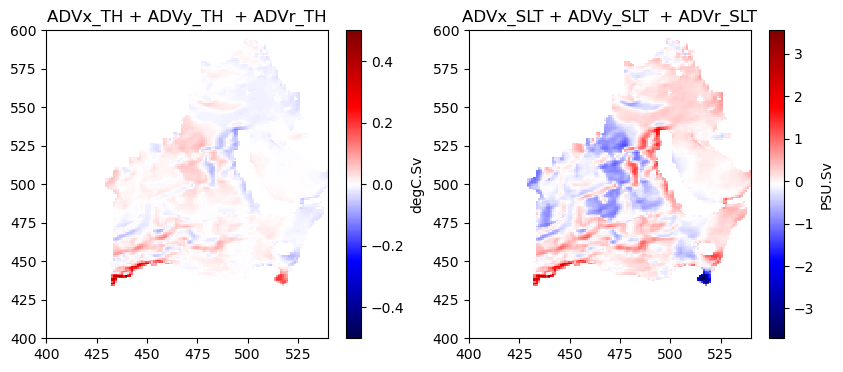

In [22]:
# what about vector sum because this is hard to look at:
fig = plt.figure(figsize=(10,4))

ax = plt.subplot(121)
cb = ax.pcolormesh(((ADVx_THo[1][0]+ADVy_THo[1][0] + (get_aste_tracer(ADVr_TH[1],nfx,nfy)[0]))*1e-6),cmap='seismic',vmin=-.5,vmax=.5)
plt.colorbar(cb,label="degC.Sv")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("ADVx_TH + ADVy_TH  + ADVr_TH")

ax = plt.subplot(122)
cb = ax.pcolormesh(((ADVx_SLTo[1][0] + ADVy_SLTo[1][0] + (get_aste_tracer(ADVr_SLT[1],nfx,nfy)[0]))*1e-6),cmap='seismic')#,vmin=-500,vmax=500)
plt.colorbar(cb,label="PSU.Sv")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("ADVx_SLT + ADVy_SLT  + ADVr_SLT")

# plt.savefig(path + "ADV_surfaceterms_summed.png", dpi=300)

# now try to calculate the vector values - we are seeing that r term is quite close to zero so not plotted above

In [23]:
# THIS LIKELY NEEDS CHANGING FROM PREVIOUS VERSION
# we already have distrADVx_SLT and distrADVx_TH, we need to repeat the process for y and z

attr_x = ADVx_TH[1][klev]
attr_y = ADVy_TH[1][klev]
attr_r = ADVr_TH[1][klev]

# let's try to write a function such that we can create these diagrams for any average or file

distr_attr_th = np.full((nT,nS),0.0)

# initialize tiles for binwidths
binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

# get the indices where not nan so that we don't have to loop, hopefully faster
indices = np.where(~np.isnan(binned_theta[1][klev]))
y,x = indices[0],indices[1]

  
for i,j in zip(y,x):
    distr_attr_th[int(binned_salinity[1][klev,i,j]),int(binned_theta[1][klev,i,j])] += attr_x[i,j]
    distr_attr_th[int(binned_salinity[1][klev,i,j]),int(binned_theta[1][klev,i,j])] += attr_y[i,j]
    distr_attr_th[int(binned_salinity[1][klev,i,j]),int(binned_theta[1][klev,i,j])] += attr_r[i,j]

    # divide by binwidthsS and binwidthsT tiles
    # heat tendency becomes Sv/PSU, salt tendency becomes Sv/degC
distr_attr_th  = distr_attr_th/binwidthsT_tile[:,:]/binwidthsS_tile[:,:]    # m^3/s/PSU
distr_attr_th *= 1e-6                                                    # Sv/PSU
distr_attr_th[distr_attr_th == 0 ] = np.nan

In [24]:
# THIS LIKELY NEEDS CHANGING FROM PREVIOUS VERSION
# we already have distrADVx_SLT and distrADVx_TH, we need to repeat the process for y and z

attr_x = ADVx_SLT[1][0]
attr_y = ADVy_SLT[1][0]
attr_r = ADVr_SLT[1][0]

# let's try to write a function such that we can create these diagrams for any average or file

distr_attr_slt = np.full((nT,nS),0.0)

# initialize tiles for binwidths
binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

# get the indices where not nan so that we don't have to loop, hopefully faster
indices = np.where(~np.isnan(binned_theta[1][klev]))
y,x = indices[0],indices[1]

  
for i,j in zip(y,x):
    distr_attr_slt[int(binned_salinity[1][klev,i,j]),int(binned_theta[1][klev,i,j])] += attr_x[i,j]
    distr_attr_slt[int(binned_salinity[1][klev,i,j]),int(binned_theta[1][klev,i,j])] += attr_y[i,j]
    distr_attr_slt[int(binned_salinity[1][klev,i,j]),int(binned_theta[1][klev,i,j])] += attr_r[i,j]

    # divide by binwidthsS and binwidthsT tiles
    # heat tendency becomes Sv/PSU, salt tendency becomes Sv/degC
distr_attr_slt  = distr_attr_slt/binwidthsT_tile[:,:]/binwidthsS_tile[:,:]    # m^3/s/degC
distr_attr_slt *= 1e-6                                                    # Sv/degC
distr_attr_slt[distr_attr_slt == 0 ] = np.nan

# plot on the mesh of the surface volume

In [25]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

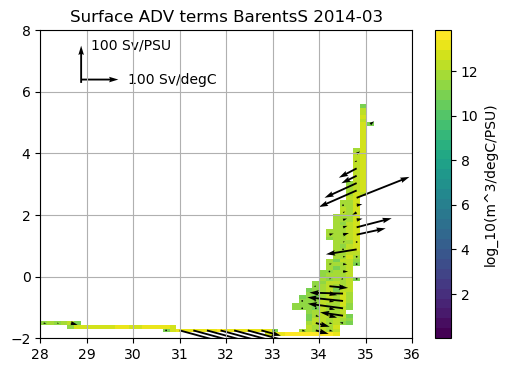

In [26]:
# try to plot GS and GT

# remake the previous figure with scaled arrows
fig = plt.figure(figsize=(6,4))

sfact = 6   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = m
U = 100
# U = 1
scale=1e3

ax1 = plt.subplot(111)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
U1, V1 = distr_attr_slt/5,distr_attr_th
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("Surface ADV terms " + strb[iB] + " " + datetimes[0].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2,8)
ax1.grid()
# ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
# ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)


ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)


# plt.savefig(path + "Jterms_Barents_bad.png",dpi=300)

In [27]:
adv_distr_attr_th = distr_attr_th.copy()
adv_distr_attr_slt = distr_attr_slt.copy()

# Let's repeat this exersize with the surface diffusive term

Text(0.5, 1.0, 'DF y SLT')

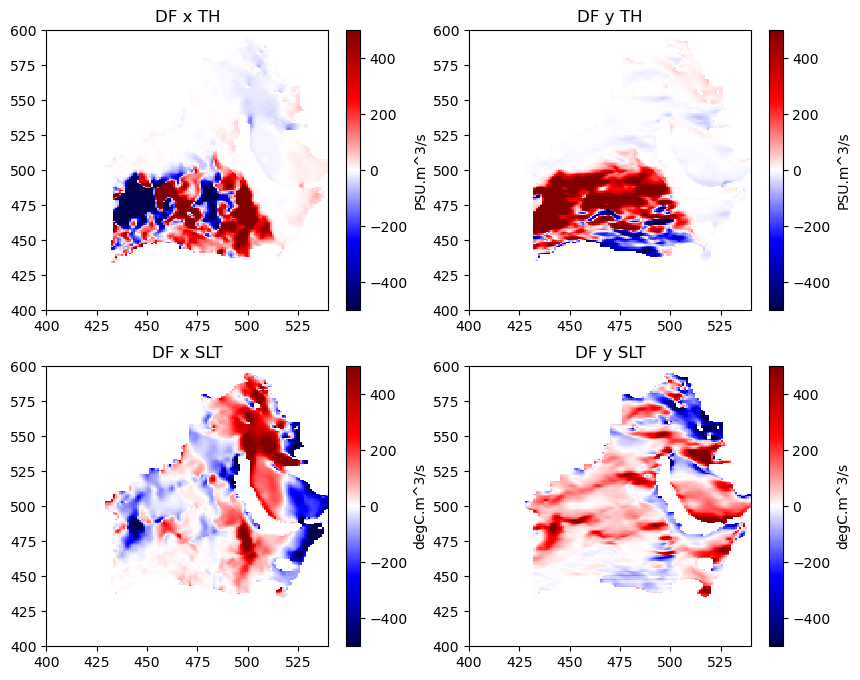

In [28]:
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(221)
cb = ax.pcolormesh((DFxE_THo[1][klev]),cmap='seismic',vmin=-500,vmax=500)
plt.colorbar(cb,label="PSU.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("DF x TH")

ax = plt.subplot(222)
cb = ax.pcolormesh((DFyE_THo[1][klev]),cmap='seismic',vmin=-500,vmax=500)
plt.colorbar(cb,label="PSU.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("DF y TH")

# ax = plt.subplot(233)
# cb = ax.pcolormesh(get_aste_tracer(ADVr_TH[1],nfx,nfy)[0],cmap='seismic')
# # plt.colorbar(cb)
# ax.set_xlim(400,540)
# ax.set_ylim(400,600)

ax = plt.subplot(223)
cb = ax.pcolormesh((DFxE_SLTo[1][klev]),cmap='seismic',vmin=-500,vmax=500)
plt.colorbar(cb,label="degC.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("DF x SLT")

ax = plt.subplot(224)
cb = ax.pcolormesh((DFyE_SLTo[1][klev]),cmap='seismic',vmin=-500,vmax=500)
plt.colorbar(cb,label="degC.m^3/s")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("DF y SLT")

# plt.savefig(path + "DFterms_mapview.png",dpi=300)

Text(0.5, 1.0, 'DFxE_SLT + DFyE_SLT + DFrE_SLT')

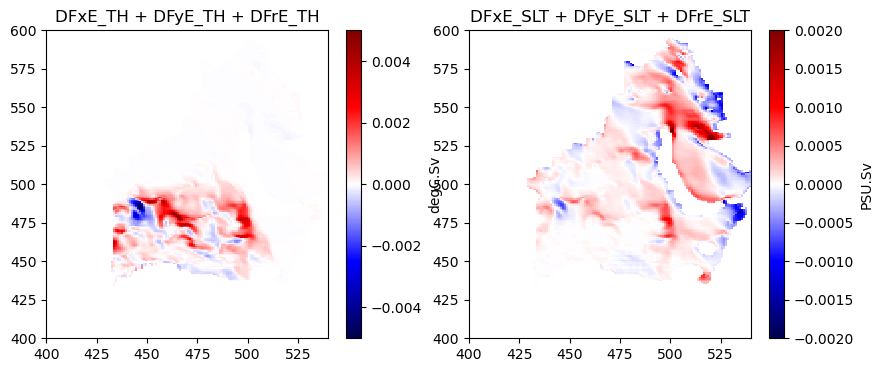

In [29]:
# what about vector sum because this is hard to look at:
fig = plt.figure(figsize=(10,4))

ax = plt.subplot(121)
cb = ax.pcolormesh(((DFxE_THo[1][klev]+DFyE_THo[1][klev] + (get_aste_tracer(DFrE_TH[1],nfx,nfy)[0]))*1e-6),cmap='seismic',vmin=-5e-3,vmax=5e-3)
plt.colorbar(cb,label="degC.Sv")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("DFxE_TH + DFyE_TH + DFrE_TH")

ax = plt.subplot(122)
cb = ax.pcolormesh(((DFxE_SLTo[1][klev] + DFyE_SLTo[1][klev] + (get_aste_tracer(DFrE_SLT[1],nfx,nfy)[0]))*1e-6),cmap='seismic',vmin=-2e-3,vmax=2e-3)
plt.colorbar(cb,label="PSU.Sv")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("DFxE_SLT + DFyE_SLT + DFrE_SLT")

# plt.savefig(path + "DF_surfaceterms_summed.png", dpi=300)

In [30]:
# THIS LIKELY NEEDS CHANGING FROM PREVIOUS VERSION
# we already have distrADVx_SLT and distrADVx_TH, we need to repeat the process for y and z

attr_x = DFxE_TH[1][klev]
attr_y = DFyE_TH[1][klev]
attr_r = DFrE_TH[1][klev]

# let's try to write a function such that we can create these diagrams for any average or file

distr_attr_th = np.full((nT,nS),0.0)

# initialize tiles for binwidths
binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

# get the indices where not nan so that we don't have to loop, hopefully faster
indices = np.where(~np.isnan(binned_theta[1][klev]))
y,x = indices[0],indices[1]

  
for i,j in zip(y,x):
    distr_attr_th[int(binned_salinity[1][klev,i,j]),int(binned_theta[1][klev,i,j])] += attr_x[i,j]
    distr_attr_th[int(binned_salinity[1][klev,i,j]),int(binned_theta[1][klev,i,j])] += attr_y[i,j]
    distr_attr_th[int(binned_salinity[1][klev,i,j]),int(binned_theta[1][klev,i,j])] += attr_r[i,j]

    # divide by binwidthsS and binwidthsT tiles
    # heat tendency becomes Sv/PSU, salt tendency becomes Sv/degC
distr_attr_th  = distr_attr_th/binwidthsT_tile[:,:]/binwidthsS_tile[:,:]    # m^3/s/PSU
distr_attr_th *= 1e-6                                                    # Sv/PSU
distr_attr_th[distr_attr_th == 0 ] = np.nan

In [31]:
# THIS LIKELY NEEDS CHANGING FROM PREVIOUS VERSION
# we already have distrADVx_SLT and distrADVx_TH, we need to repeat the process for y and z

attr_x = DFxE_SLT[1][0]
attr_y = DFyE_SLT[1][0]
attr_r = DFrE_SLT[1][0]

# let's try to write a function such that we can create these diagrams for any average or file

distr_attr_slt = np.full((nT,nS),0.0)

# initialize tiles for binwidths
binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

# get the indices where not nan so that we don't have to loop, hopefully faster
indices = np.where(~np.isnan(binned_theta[1][klev]))
y,x = indices[0],indices[1]

  
for i,j in zip(y,x):
    distr_attr_slt[int(binned_salinity[1][klev,i,j]),int(binned_theta[1][klev,i,j])] += attr_x[i,j]
    distr_attr_slt[int(binned_salinity[1][klev,i,j]),int(binned_theta[1][klev,i,j])] += attr_y[i,j]
    distr_attr_slt[int(binned_salinity[1][klev,i,j]),int(binned_theta[1][klev,i,j])] += attr_r[i,j]

    # divide by binwidthsS and binwidthsT tiles
    # heat tendency becomes Sv/PSU, salt tendency becomes Sv/degC
distr_attr_slt  = distr_attr_slt/binwidthsT_tile[:,:]/binwidthsS_tile[:,:]    # m^3/s/degC
distr_attr_slt *= 1e-6                                                    # Sv/degC
distr_attr_slt[distr_attr_slt == 0 ] = np.nan

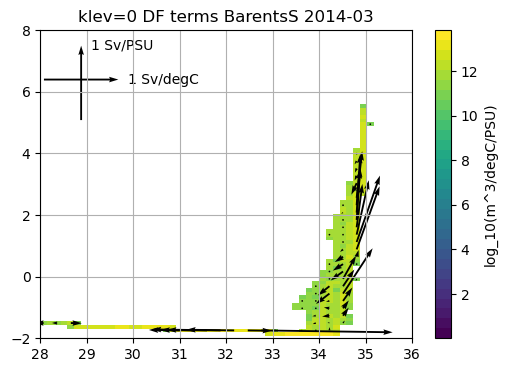

In [32]:
# try to plot GS and GT

# remake the previous figure with scaled arrows
fig = plt.figure(figsize=(6,4))

sfact = 6   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = m
U = 1
# U = 1
scale=5

ax1 = plt.subplot(111)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
U1, V1 = distr_attr_slt,distr_attr_th/4
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("klev="+ str(klev) + " DF terms " + strb[iB] + " " + datetimes[0].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2,8)
ax1.grid()
# ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
# ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)


ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)


# plt.savefig(path + "Jterms_Barents_bad.png",dpi=300)

In [33]:
df_distr_attr_th = distr_attr_th.copy()
df_distr_attr_slt = distr_attr_slt.copy()

# calculate G_S and G_T

In [34]:
# do salt tendency
# Initialize the new array with the desired shape (2, z, y, x)
dSALTDRdt = np.zeros((1, SALTDR.shape[1], SALTDR.shape[2], SALTDR.shape[3]))
# Calculate the differences and assign to the new array
dSALTDRdt[0] = (SALTDR[1] - SALTDR[0]) / (datetimes[1]-datetimes[0]).total_seconds()
# dSALTDRdt[1] = (SALTDR[3] - SALTDR[2])  / (datetimes[3]-datetimes[2]).total_seconds()
print(dSALTDRdt.shape)    # PSU.m  / s

# now calculate the tendency for the two months times[0], times[2]
AB_gS = 0
G_S = np.zeros((1, SALTDR.shape[1], SALTDR.shape[2], SALTDR.shape[3]))
for i in range(dSALTDRdt.shape[0]):
    G_S[i] = (dSALTDRdt[i] - AB_gS) * mk3D_mod(RAC,dSALTDRdt[i])   # PSU.m/s * m^2 = PSU.m^3/s

(1, 50, 1350, 270)


In [35]:
# do heat tendency
# Initialize the new array with the desired shape (2, z, y, x)
dTHETADRdt = np.zeros((1, THETADR.shape[1], THETADR.shape[2], THETADR.shape[3]))
# Calculate the differences and assign to the new array
dTHETADRdt[0] = (THETADR[1] - THETADR[0]) / (datetimes[1]-datetimes[0]).total_seconds()
# dTHETADRdt[1] = (THETADR[3] - THETADR[2]) / (datetimes[3]-datetimes[2]).total_seconds()
print(dTHETADRdt.shape)    # degC.m / s

# now calculate the tendency for the two months times[0], times[2]
G_T = np.zeros((1, THETADR.shape[1], THETADR.shape[2], THETADR.shape[3]))
for i in range(dTHETADRdt.shape[0]):
    G_T[i] = (dTHETADRdt[i]-AB_gT)*mk3D_mod(RAC,dTHETADRdt[i])     # degC.m/s * m^2 = degC.m^3/s

(1, 50, 1350, 270)


In [36]:
# do surface vectors
if klev == 0:    # surface, set below to nan
    surf_G_S_m1 = G_S[0].copy()
    surf_G_S_m1[1:,:,:] = np.nan
    surf_G_T_m1 = G_T[0].copy()
    surf_G_T_m1[1:,:,:] = np.nan
else:
    surf_G_S_m1 = G_S[0].copy()
    surf_G_S_m1[:klev,:,:] = np.nan
    surf_G_S_m1[klev+1:,:,:] = np.nan
    surf_G_T_m1 = G_T[0].copy()
    surf_G_T_m1[:klev,:,:] = np.nan
    surf_G_T_m1[klev+1:,:,:] = np.nan


# same for binned values, can set below to nan
if klev == 0:
    surf_binned_theta_m1 = binned_theta[1]
    surf_binned_theta_m1[1:,:,:] = np.nan
    surf_binned_salinity_m1 = binned_salinity[1]
    surf_binned_salinity_m1[1:,:,:] = np.nan
else:
    surf_binned_theta_m1 = binned_theta[1]
    surf_binned_theta_m1[:klev,:,:] = np.nan
    surf_binned_theta_m1[klev+1:,:,:] = np.nan
    surf_binned_salinity_m1 = binned_salinity[1]
    surf_binned_salinity_m1[:klev,:,:] = np.nan
    surf_binned_salinity_m1[klev+1:,:,:] = np.nan

# do total vectors - skip cell if previous is done
J_x_vec_m1 = calc_G_term(surf_G_S_m1,surf_binned_theta_m1,surf_binned_salinity_m1,nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # PSU.m^3/s -> Sv/degC
J_y_vec_m1 = calc_G_term(surf_G_T_m1,surf_binned_theta_m1,surf_binned_salinity_m1,nT,nS,binwidthS,binwidthT)/binwidthsS_tile/binwidthsT_tile    # Sv/PSU

In [37]:
surf_binned_theta_m1 = binned_theta[0]

np.nansum(surf_binned_salinity_m1)

702310.0

# The Previous seems to be correct, can we compare this to the total tendency?

In [38]:
# # first let's make sure we have the right variables
# adv_distr_attr_th
# adv_distr_attr_slt
# df_distr_attr_th
# df_distr_attr_slt
# J_x_vec_m1
# J_y_vec_m1

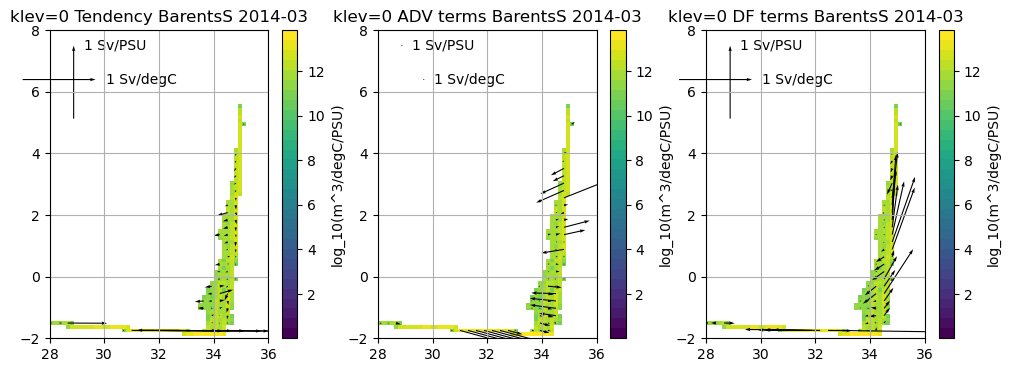

In [41]:
# try to plot GS and GT

# remake the previous figure with scaled arrows
fig = plt.figure(figsize=(12,4))

sfact = 6   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = m
U = 1
# U = 1
scale=5


# try to plot GS and GT
# total
ax1 = plt.subplot(131)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
U1, V1 = J_x_vec_m1,J_y_vec_m1/12
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=3)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("klev=" + str(klev) + " Tendency " + strb[iB] + " " + datetimes[0].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2,8)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)


# adv
ax1 = plt.subplot(132)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
U1, V1 = adv_distr_attr_slt/5,adv_distr_attr_th
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=8e2)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("klev=" + str(klev) + " ADV terms " + strb[iB] + " " + datetimes[0].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2,8)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)


# df
ax1 = plt.subplot(133)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
U1, V1 = df_distr_attr_slt,df_distr_attr_th/4
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=3)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("klev=" + str(klev) + " DF terms " + strb[iB] + " " + datetimes[0].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-2,8)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)


plt.savefig(path + "BarentsS_sample_tend_adv_df.png",dpi=300)

In [ ]:
fig = plt.figure()

ax = plt.subplot(121)
cb = ax.pcolormesh(get_aste_tracer(G_S[0][0],nfx,nfy)[0],cmap='seismic',vmin=-1000,vmax=1000)
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("klev=" + str(klev) + " salt tend")
plt.colorbar(cb,label="PSU.m^3/s")

ax = plt.subplot(122)
cb = ax.pcolormesh(get_aste_tracer(G_T[0][0],nfx,nfy)[0],cmap='seismic',vmin=-1000,vmax=1000)
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("klev=" + str(klev) + " heat tend")
plt.colorbar(cb,label="degC.m^3/s")

# plt.savefig(path + "BarentsS_march_salttend_heattend_map.png",dpi=300)

# let's look closer at one specific portion of the advection plot - say T_F

In [ ]:
# U1, V1 = adv_distr_attr_slt/5,adv_distr_attr_th
# plt.pcolormesh(adv_distr_attr_slt)
# plt.colorbar()
# plt.xlim(9,10)
# plt.ylim(65,75)

isalt = 69
itheta = 9

adv_distr_attr_slt[69,9]   # this is some random point at binsSLT_edges[69], binsTH_edges[9]

In [ ]:
binned_salinity.shape

In [ ]:
# create some mask to look only at this water mass
idxs_sl = np.where(binned_salinity[1] == 69)
idxs_th = np.where(binned_theta[1] == 9)

msk_sel = np.zeros((nz,ny,nx))


for k,i,j in zip(idxs_sl[0],idxs_sl[1],idxs_sl[2]):
    msk_sel[k,i,j] += 1


for k,i,j in zip(idxs_th[0],idxs_th[1],idxs_th[2]):
    msk_sel[k,i,j] += 1

In [ ]:
msk_sel[msk_sel ==1] = 0    # we're only interested where it's the index
msk_sel[msk_sel ==0] = np.nan

In [ ]:
plt.pcolormesh(get_aste_tracer(msk_sel,nfx,nfy)[klev]*ADVx_SLTo[1][klev])
plt.colorbar()
plt.xlim(400,540)
plt.ylim(400,600)

# try to add the surface forcing then go back to look at ADV
Steps:
1. Go back to the budgeting files for heat and salt; what terms do we need?
2. Look for the file (surface_forcing_tendencies.ipynb) where we did surface forcing for oceFWflx - copy this code here to look more closely
3. Compare what we see in the WMT to the changes in each term at the surface - do things make sense?
4. Look back at the budgeting code specifically at ADV terms, are we looking for dADV/dt or just the advection; ie is this why the TS plot is so far off in previous? -- NO, the only thing we do time -averaging (/ dt) for is the ETAN or budg2d_snap_set1

In [ ]:
# for 1, heat:
budgO_heat = {}
budgI_heat = {}
budgO_heat['zconv']=TFLUX  # W/m^2     #+geothFlux+SPforcT1
budgI_heat['zconv']=-(SItflux+TFLUX) #-TRELAX+SPforcT1)

# for 1, salt:
budgO_salt = {}
budgI_salt = {}
budgO_salt['zconv'] = SFLUX + oceSPflx   # g/m^2/s
budgI_salt['zconv'] = -budgO_salt['zconv']

In [ ]:
# for SALT terms
def get_surface_distr_fw(indices,attr,month,RAC,nT,nS,binned_salinity,binned_theta,rhoconst):
    # get the surface values of the attribute
    attr_sel = attr[month] * RAC / rhoconst * 1e-6    # (kg/m^2/s) * (m^2) / (kg/m^3) = m^3/s = Sv
    attr_sel = attr_sel   # negative because freshening
    
    # initialize the mesh
    mesh = np.full((nT,nS),0.0)

    # add at the bins - this part might be wrong
    for i,j in zip(indices[0],indices[1]):
        mesh[int(binned_salinity[month][0,i,j]),int(binned_theta[month][0,i,j])] += attr_sel[i,j]
    
    # normalize by the bin widths in S and T
    fX = mesh / binwidthsS_tile / binwidthsT_tile     # Sv/degC/PSU
    fY = mesh / binwidthsS_tile / binwidthsT_tile     # Sv/degC/PSU

    # do the dividing or normalizing
    integral_fX_dT  = (fX * binwidthsT_tile)      # Sv/PSU
    integral_fY_dS  = np.zeros_like(integral_fX_dT)
    integral_fX_dT[integral_fX_dT == 0] = np.nan

    return(integral_fX_dT,integral_fY_dS)       # Sv/PSU

In [ ]:
# for HEAT terms
def get_surface_distr_heat(indices,attr,month,RAC,nT,nS,binned_salinity,binned_theta,rcp):
    # get the surface values of the attribute
    attr_sel = attr[month] * RAC / rcp * 1e-6    # (W/m^2) * (m^2) / (J/m^3 deg C) * 1e-6 = Sv*degC
    
    # initialize the mesh
    mesh = np.full((nT,nS),0.0)

    # add at the bins - this part might be wrong
    for i,j in zip(indices[0],indices[1]):
        mesh[int(binned_salinity[month][0,i,j]),int(binned_theta[month][0,i,j])] += attr_sel[i,j]    # Sv*degC
    
    # normalize by the bin widths in S and T
    #fX = mesh / binwidthsS_tile / binwidthsT_tile     # Sv/degC/PSU
    fY = mesh / binwidthsT_tile #/ binwidthsT_tile     # Sv/degC/PSU

    # do the dividing or normalizing
    integral_fY_dS  = fY * binwidthsS_tile  # Sv/degC  np.zeros_like(integral_fX_dT)
    integral_fX_dT  = np.zeros_like(integral_fY_dS)
    integral_fY_dS[integral_fY_dS == 0] = np.nan

    return(integral_fX_dT,integral_fY_dS)       # Sv/degC

In [ ]:
# let's start with the ocean terms for heat ie budgO_heat[zconv]
# try syntax for one just to get started
month = 1   # index for snap at the end of the averaged month
surfheatOx_dS,surfheatOy_dS = get_surface_distr_heat(indices,budgO_heat['zconv'],month,RAC,nT,nS,binned_salinity,binned_theta,myparms['rcp'])
surfheatIx_dS,surfheatIy_dS = get_surface_distr_heat(indices,budgI_heat['zconv'],month,RAC,nT,nS,binned_salinity,binned_theta,myparms['rcp'])
# input degC.m^3/s the above are now in units of Sv/PSU or y term

In [ ]:
# do for heat also with budgO_
month = 1   # index for snap at the end of the averaged month
surfsaltOx_dT,surfsaltOy_dT = get_surface_distr_fw(indices,budgO_salt['zconv'],month,RAC,nT,nS,binned_salinity,binned_theta,myparms['rhoconst'])
surfsaltIx_dT,surfsaltIy_dT = get_surface_distr_fw(indices,budgI_salt['zconv'],month,RAC,nT,nS,binned_salinity,binned_theta,myparms['rhoconst'])
# input PSU.m^3/s the above are now in units of Sv/degC or x term

In [ ]:
# we actually don't need to use the x term for heat or the y term for salt
# try to plot these two here

# remake the previous figure with scaled arrows
fig = plt.figure(figsize=(12,4))

sfact = 6   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = m
U = 1e-2
# U = 1
scale=1e-1


# try to plot GS and GT
# total
ax1 = plt.subplot(121)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
U1, V1 = surfsaltOx_dT,surfheatOy_dS/12
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("TFLUX vs (SFLUX + oceSPflx) " + strb[iB] + " " + datetimes[0].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-3,8)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)


# adv
ax1 = plt.subplot(122)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
U1, V1 = surfsaltIx_dT,surfheatIy_dS/12
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=scale)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("-(SItflux+TFLUX) vs -(SFLUX + oceSPflx) " + strb[iB] + " " + datetimes[0].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-3,8)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)

plt.savefig(path + "BarentsS_surface_zconvterms.png",dpi=300)

In [ ]:
# also plot these in x-y to look more carefully
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(221)
cb = ax.pcolormesh(get_aste_tracer(budgO_salt['zconv'][1],nfx,nfy)[0]*1e-6,cmap='seismic',vmin=-1e-9,vmax=1e-9)
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("SFLUX + oceSPflx")
plt.colorbar(cb,label="PSU.Sv")

ax = plt.subplot(222)
cb = ax.pcolormesh(get_aste_tracer(budgO_heat['zconv'][1],nfx,nfy)[0]*1e-6,cmap='seismic',vmin=-1e-4,vmax=1e-4)
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("TFLUX")
plt.colorbar(cb,label="degC.Sv")

ax = plt.subplot(223)
cb = ax.pcolormesh(get_aste_tracer(budgI_salt['zconv'][1],nfx,nfy)[0]*1e-6,cmap='seismic',vmin=-1e-9,vmax=1e-9)
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("-(SFLUX + oceSPflx)")
plt.colorbar(cb,label="degC.Sv")

ax = plt.subplot(224)
cb = ax.pcolormesh(get_aste_tracer(budgI_heat['zconv'][1],nfx,nfy)[0]*1e-6,cmap='seismic',vmin=-2e-4,vmax=2e-4)
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("-(SItflux+TFLUX)")
plt.colorbar(cb,label="degC.Sv")

plt.savefig(path + "BarentsS_surface_zconvterms_mapview.png",dpi=300)

# this seems to be accurate based on what we're plotting... time to look deeper at the budget itself

# when we do the budgeting, we are looking at the tend-hconv-zconv, let's maybe try to calculate these to see them 

In [ ]:
# for the surface we need three terms the tendency, the hconv of ADV + DF terms, and the zconv
# I think we might want to plot with the convergence of ADV and DF terms rather than with the total terms

In [ ]:
ADVx_THo.shape   # degC.m^3/s
ADVy_THo.shape   # degC.m^3/s

In [ ]:
# let's do the hconv of these terms for heat and also for salt
tmp_surf_ADV_U = ADVx_THo[1][0]
tmp_surf_ADV_V = ADVy_THo[1][0]

hconv_ADV_TH_tracer = calc_UV_conv_1face(tmp_surf_ADV_U,tmp_surf_ADV_V)[0]
hconv_ADV_TH = aste_tracer2compact(hconv_ADV_TH_tracer,nfx,nfy)               # degC.m^3/s

# also do for salt now
tmp_surf_ADV_U = ADVx_SLTo[1][0]
tmp_surf_ADV_V = ADVy_SLTo[1][0]

hconv_ADV_SLT_tracer = calc_UV_conv_1face(tmp_surf_ADV_U,tmp_surf_ADV_V)[0]
hconv_ADV_SLT = aste_tracer2compact(hconv_ADV_SLT_tracer,nfx,nfy)             # PSU.m^3/s

In [ ]:
# plot these
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(221)
cb = ax.pcolormesh(hconv_ADV_TH_tracer*1e-6/.1/.1,cmap='seismic',vmin=-10,vmax=10)
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("hconv of ADV_TH terms")
plt.colorbar(cb,label="degC.Sv")

ax = plt.subplot(222)
cb = ax.pcolormesh(hconv_ADV_SLT_tracer*1e-6/.1/.1,cmap='seismic',vmin=-50,vmax=50)
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("hconv of ADV_SLT terms")
plt.colorbar(cb,label="PSU.Sv")

plt.savefig(path + "BarentsS_surface_advhconv.png",dpi=300)

In [ ]:
# do the vectorizing of the hconv terms for advection
month = 0

surfheatOx_dS,surfheatOy_dS = get_surface_distr_heat(indices,hconv_ADV_TH,month,RAC,nT,nS,binned_salinity,binned_theta,myparms['rcp'])
surfsaltOx_dT,surfsaltOy_dT = get_surface_distr_fw(indices,hconv_ADV_SLT,month,RAC,nT,nS,binned_salinity,binned_theta,myparms['rhoconst'])

# let's do the budgeting for these terms at the surface

In [ ]:
# let's do the hconv of these terms for heat and also for salt
tmp_surf_DF_U = DFxE_THo[1][0]
tmp_surf_DF_V = DFyE_THo[1][0]

hconv_DF_TH_tracer = calc_UV_conv_1face(tmp_surf_DF_U,tmp_surf_DF_V)[0]
hconv_DF_TH = aste_tracer2compact(hconv_DF_TH_tracer,nfx,nfy)               # degC.m^3/s

# also do for salt now
tmp_surf_DF_U = DFxE_SLTo[1][0]
tmp_surf_DF_V = DFyE_SLTo[1][0]

hconv_DF_SLT_tracer = calc_UV_conv_1face(tmp_surf_DF_U,tmp_surf_DF_V)[0]
hconv_DF_SLT = aste_tracer2compact(hconv_DF_SLT_tracer,nfx,nfy)             # PSU.m^3/s

In [ ]:
# plot these
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(221)
cb = ax.pcolormesh(hconv_DF_TH_tracer*1e-6/.1/.1,cmap='seismic',vmin=-.1,vmax=.1)
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("hconv of DF_TH terms")
plt.colorbar(cb,label="degC.Sv")

ax = plt.subplot(222)
cb = ax.pcolormesh(hconv_DF_SLT_tracer*1e-6/.1/.1,cmap='seismic',vmin=-.1,vmax=.1)
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("hconv of DF_SLT terms")
plt.colorbar(cb,label="PSU.Sv")

plt.savefig(path + "BarentsS_surface_dfhconv.png",dpi=300)

In [ ]:
# do the vectorizing of the hconv terms for advection
month = 0

surfheatOx_dS,dfsurfheatOy_dS = get_surface_distr_heat(indices,hconv_DF_TH,month,RAC,nT,nS,binned_salinity,binned_theta,myparms['rcp'])
dfsurfsaltOx_dT,surfsaltOy_dT = get_surface_distr_fw(indices,hconv_DF_SLT,month,RAC,nT,nS,binned_salinity,binned_theta,myparms['rhoconst'])

In [ ]:
# remake the previous figure with scaled arrows
fig = plt.figure(figsize=(10,4))

sfact = 6   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = m
U = 10

# try to plot GS and GT
# total
ax1 = plt.subplot(121)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
U1, V1 = surfsaltOx_dT/500000,surfheatOy_dS
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=5e1)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("h convergence of Advection " + strb[iB] + " " + datetimes[0].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-3,8)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)

U = 1

ax1  = plt.subplot(122)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
U1, V1 = dfsurfsaltOx_dT/10000,dfsurfheatOy_dS
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=1e1)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("h convergence of Diffusion " + strb[iB] + " " + datetimes[0].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-3,8)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)

plt.savefig(path + "BarentsS_surface_dfhconv.png",dpi=300)

# do zconv of these terms as well, but get in units of []m^3/s rather than in W and g

In [ ]:
# do for all terms first, then we can decompose into parts

In [ ]:
zconv_heat = TFLUX[1]+geothFlux+SPforcT1             # W/m^2


nr = mygrid['RC'].shape[0]
trWtop = -(ADVr_TH[1]+DFrE_TH[1]+DFrI_TH[1]+KPPg_TH[1])*myparms['rcp']  # degC.m^3/s  * J/m^3degC   = J/s = W
dd = mygrid['RF'][:-1]
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac[dd < -200] = 0
swtop=mk3D_mod(swfrac,trWtop)*np.tile((RAC*oceQsw[1])[np.newaxis,:,:],(nz,1,1))   # W
mskC=mygrid['mskC']
swtop[np.isnan(mskC)]=0
trWtop=trWtop+swtop  # 323
    
trWtop[0,:,:]=zconv_heat*RAC              # W
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:]=trWtop[1:,:,:]

zconv_heat=RAC3d * (trWtop-trWbot)        # W

zconv_heat /= myparms['rcp']              # J/s * m^3degC/J =  m^3.degC/s

In [ ]:
zconv_salt = SFLUX[1] + oceSPflx[1]    # g/m^2/s, second timestep because we only loaded two

nr = mygrid['RC'].shape[0]
trWtop = -(ADVr_SLT[1]+DFrE_SLT[1]+DFrI_SLT[1]+KPPg_SLT[1])*myparms['rhoconst']      # PSU.m^3/s * kg/m^3 = g/s 
print(trWtop.shape)
tmp1 = np.tile(oceSPflx[1][np.newaxis,:,:],(nz,1,1)) - np.cumsum(oceSPtnd[1], axis=0)
tmp1 = tmp1 * RAC3                                                                    # g/s

trWtop[1:,:,:] = trWtop[1:,:,:] + tmp1[:-1,:,:]
trWtop[0,:,:] = zconv_salt * RAC                                               # g/s

trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:] = trWtop[1:,:,:]
trWbot[-1,:,:] = 0

zconv_salt = (trWtop - trWbot)/ myparms['rhoconst']                            # PSU.m^3/s

In [ ]:
# now do binning to create vectors for both

month = 0

surfheatOx_dS,surfheatOy_dS = get_surface_distr_heat(indices,zconv_heat[0].reshape(1,ny,nx),month,RAC,nT,nS,binned_salinity,binned_theta,myparms['rcp'])
surfsaltOx_dT,surfsaltOy_dT = get_surface_distr_fw(indices,zconv_salt[0].reshape(1,ny,nx),month,RAC,nT,nS,binned_salinity,binned_theta,myparms['rhoconst'])

In [ ]:
fig = plt.figure(figsize=(5,4))

sfact = 6   # scale factor for x (PSU in denom, multiply out)
arrow_length = 0.25     # for the sverdrup arrows
step=2
t = m
U = 10

# try to plot GS and GT
# total
ax1 = plt.subplot(111)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
U1, V1 = surfsaltOx_dT,surfheatOy_dS/1000
q1 = ax1.quiver(Sbincent[::step,::step], Tbincent[::step,::step], U1[::step,::step], V1[::step,::step], width=0.005,scale=5e7)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("z convergence totally " + strb[iB] + " " + datetimes[0].strftime("%Y-%m"))
ax1.set_xlim(28,36)
ax1.set_ylim(-3,8)
ax1.grid()
ax1.quiverkey(q1, X=0.21, Y=0.84, U=U, label=str(U) + " Sv/degC", labelpos='E')
ax1.quiverkey(q1, X=0.11, Y=0.95, U=U, label=str(U) + " Sv/PSU", labelpos='E',angle = 90)

plt.savefig(path + "zconv_BarentsS_total.png",dpi=300)

# Let's do for one grid box - this is what An will advise

In [383]:
np.arange(1,270,1).shape

(269,)

In [384]:
# y = 434
# x = 162

y = 500
x = 25

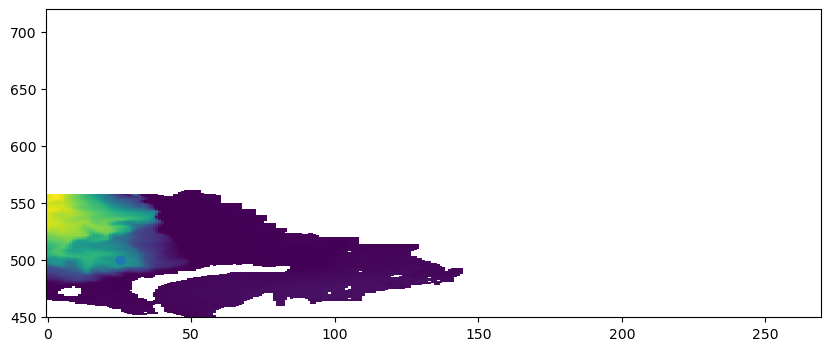

In [385]:
XV,YV = np.meshgrid(np.arange(0,270,1),np.arange(450,720,1))

    # Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

plt.pcolormesh(XV,YV,theta[1][0][450:720,:270])
plt.plot(x,y,'o')
# plt.xlim(400,540)
# plt.ylim(400,600)

In [386]:
THETA.shape

(50, 1350, 270)

In [387]:
THETA[0,y,x]

1.627448558807373

In [388]:
SALT[0,y,x]

34.803131103515625

In [389]:
print(SIarea[y,x],SIheff[y,x])

0.0 0.0


In [390]:
print(TFLUX[1][y,x])
print(SItflux[1][y,x])
print(oceQsw[1][y,x])

-117.69079008170229
117.69079008170232
53.46127912452661


In [391]:
print(oceQnet[y,x])
print(WTHMASS[y,x])
print(SIaaflux[y,x])

-117.69708771630734
-1.5323360661102166e-09
0.0


In [392]:
print(ADVx_TH[1][0,y,x],ADVx_TH[1][0,y,x+1])
print(ADVy_TH[1][0,y,x],ADVy_TH[1][0,y+1,x])
print(ADVr_TH[1][0,y,x],ADVr_TH[1][1,y,x])

print()
print(DFxE_TH[1][0,y,x],DFxE_TH[1][0,y,x+1])
print(DFyE_TH[1][0,y,x],DFyE_TH[1][0,y+1,x])
print(DFrE_TH[1][0,y,x],DFrE_TH[1][1,y,x])
print(DFrI_TH[1][0,y,x],DFrI_TH[1][1,y,x])


print()
print(KPPg_TH[1][0,y,x],KPPg_TH[1][1,y,x])

print()

2977.9222738035805 5817.063552127806
3086.6964199512245 -5529.85870168584
0.0 -5508.767209934892

190.83224234027426 179.3436553833449
203.4720272947743 -63.18779340440642
0.0 515.5353671940732
0.0 3341.3762641706853

0.0 1618.791566194125



In [393]:
def calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo):

    # face 1
    tmpUo_p1 = structtype()
    tmpUo_p1.f1 = np.full((tmpUo.f1.shape[0],tmpUo.f1.shape[1],tmpUo.f1.shape[2]+1),np.nan)
    tmpUo_p1.f1[:,:,:nfx[0]] = tmpUo.f1
    
    tmpVo_p1 = structtype()
    tmpVo_p1.f1 = np.full((tmpVo.f1.shape[0],tmpVo.f1.shape[1]+1,tmpVo.f1.shape[2]),np.nan)
    tmpVo_p1.f1[:,:nfy[0],:] = tmpVo.f1

    # face 3
    tmpUo_p1.f3 = np.full((tmpUo.f3.shape[0],tmpUo.f3.shape[1],tmpUo.f3.shape[2]+1),np.nan)
    tmpUo_p1.f3[:,:,:nfx[2]] = tmpUo.f3
    
    tmpVo_p1.f3 = np.full((tmpVo.f3.shape[0],tmpVo.f3.shape[1]+1,tmpVo.f3.shape[2]),np.nan)
    tmpVo_p1.f3[:,:nfy[2],:] = tmpVo.f3

    # face 4
    tmpUo_p1.f4 = np.full((tmpUo.f4.shape[0],tmpUo.f4.shape[1],tmpUo.f4.shape[2]+1),np.nan)
    tmpUo_p1.f4[:,:,:nfx[3]] = tmpUo.f4
    
    tmpVo_p1.f4 = np.full((tmpVo.f4.shape[0],tmpVo.f4.shape[1]+1,tmpVo.f4.shape[2]),np.nan)
    tmpVo_p1.f4[:,:nfy[3],:] = tmpVo.f4

    # face 5
    tmpUo_p1.f5 = np.full((tmpUo.f5.shape[0],tmpUo.f5.shape[1],tmpUo.f5.shape[2]+1),np.nan)
    tmpUo_p1.f5[:,:,:nfx[4]] = tmpUo.f5
    
    tmpVo_p1.f5 = np.full((tmpVo.f5.shape[0],tmpVo.f5.shape[1]+1,tmpVo.f5.shape[2]),np.nan)
    tmpVo_p1.f5[:,:nfy[4],:] = tmpVo.f5


    # do the convergence this time here
    convU = structtype()
    convV = structtype()
    
    convU.f1 = np.full((tmpUo.f1.shape[0],tmpUo.f1.shape[1],tmpUo.f1.shape[2]),np.nan)
    convU.f1 = tmpUo_p1.f1[:,:,:-1] - tmpUo_p1.f1[:,:,1:]
    convV.f1 = np.full((tmpVo.f1.shape[0],tmpVo.f1.shape[1],tmpVo.f1.shape[2]),np.nan)
    convV.f1 = tmpVo_p1.f1[:,:-1,:] - tmpVo_p1.f1[:,1:,:]

    convU.f3 = np.full((tmpUo.f3.shape[0],tmpUo.f3.shape[1],tmpUo.f3.shape[2]),np.nan)
    convU.f3 = tmpUo_p1.f3[:,:,:-1] - tmpUo_p1.f3[:,:,1:]
    convV.f3 = np.full((tmpVo.f3.shape[0],tmpVo.f3.shape[1],tmpVo.f3.shape[2]),np.nan)
    convV.f3 = tmpVo_p1.f3[:,:-1,:] - tmpVo_p1.f3[:,1:,:]

    convU.f4 = np.full((tmpUo.f4.shape[0],tmpUo.f4.shape[1],tmpUo.f4.shape[2]),np.nan)
    convU.f4 = tmpUo_p1.f4[:,:,:-1] - tmpUo_p1.f4[:,:,1:]
    convV.f4 = np.full((tmpVo.f4.shape[0],tmpVo.f4.shape[1],tmpVo.f4.shape[2]),np.nan)
    convV.f4 = tmpVo_p1.f4[:,:-1,:] - tmpVo_p1.f4[:,1:,:]

    convU.f5 = np.full((tmpUo.f5.shape[0],tmpUo.f5.shape[1],tmpUo.f5.shape[2]),np.nan)
    convU.f5 = tmpUo_p1.f5[:,:,:-1] - tmpUo_p1.f5[:,:,1:]
    convV.f5 = np.full((tmpVo.f5.shape[0],tmpVo.f5.shape[1],tmpVo.f5.shape[2]),np.nan)
    convV.f5 = tmpVo_p1.f5[:,:-1,:] - tmpVo_p1.f5[:,1:,:]

    # return to compact form
    convU_compact = aste_faces2compact(convU,nfx,nfy)
    convV_compact = aste_faces2compact(convV,nfx,nfy)
    
    return(convU_compact+convV_compact)

In [394]:
tmpUo = get_aste_faces(ADVx_TH[1],nfx,nfy)
tmpVo = get_aste_faces(ADVy_TH[1],nfx,nfy)
ADV_THhconv = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp']   # W/s

tmpUo = get_aste_faces(DFxE_TH[1],nfx,nfy)
tmpVo = get_aste_faces(DFyE_TH[1],nfx,nfy)
DFE_THhconv = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp']

In [395]:
RAC3d[0,y,x]

192366447.46567982

In [396]:
myparms['rcp']

4109826

In [397]:
print(ADVr_TH[1][0,y,x],ADVr_TH[1][1,y,x])

print()
print(DFrE_TH[1][0,y,x],DFrE_TH[1][1,y,x])
print(DFrI_TH[1][0,y,x],DFrI_TH[1][1,y,x])

print()
print(KPPg_TH[1][0,y,x],KPPg_TH[1][1,y,x])

print()


# trWtop = -(ADVr_TH[1]+DFrE_TH[1]+DFrI_TH[1]+KPPg_TH[1])*myparms['rcp']   #  degC.m^3/s * J/m^3degC = J/s
trWtopADV = -(ADVr_TH[1])*myparms['rcp']   #  degC.m^3/s * J/m^3degC = J/s
trWtopDF = -(DFrE_TH[1]+DFrI_TH[1])*myparms['rcp']   #  degC.m^3/s * J/m^3degC = J/s
trWtopKPP = -(KPPg_TH[1])*myparms['rcp']   #  degC.m^3/s * J/m^3degC = J/s
trWtop = trWtopADV + trWtopDF + trWtopKPP

# print(trWtop[0,y,x],trWtop[1,y,x])

0.0 -5508.767209934892

0.0 515.5353671940732
0.0 3341.3762641706853

0.0 1618.791566194125



In [398]:
print(trWtopADV[0,y,x] - trWtopADV[1,y,x])

-22640074707.33788


In [399]:
print(trWtop[0,y,x],trWtop[1,y,x])

-0.0 135887337.72724438


In [400]:
zconv_top = TFLUX[1] * RAC      # W/m^2 * RAC

In [401]:
dd = mygrid['RF'][:-1]
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac[dd < -200] = 0

trWtop_swtop= np.tile(swfrac[:,np.newaxis,np.newaxis],(1,ny,nx))  * RAC3d * np.tile(oceQsw[1][np.newaxis,:,:],(nz,1,1))   # W/m^2 * m^2
mskC=mygrid['mskC']


trWtop_swtop[np.isnan(mskC)]=0

print(trWtop_swtop[0,y,x],trWtop_swtop[1,y,x])

print(trWtop[0,y,x],trWtop[1,y,x])


trWtop=trWtop+trWtop_swtop  # 323

print(trWtop[0,y,x],trWtop[1,y,x])

# print(trWtop[0,y,x],trWtop[1,y,x])

trWtop[0,:,:] = zconv_top.reshape(1,ny,nx)
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:]=trWtop[1:,:,:]

10284156342.156294 2370309698.101918
-0.0 135887337.72724438
10284156342.156294 2506197035.8291626


In [402]:
print(trWtop[0,y,x],trWtop[1,y,x])
print(trWbot[0,y,x])

-22639759187.446136 2506197035.8291626
2506197035.8291626


In [403]:
print(ADV_THhconv[0,y,x])
print(DFE_THhconv[0,y,x])

23744165626.00703
1143141557.64368


In [404]:
# # check tend again
# G_T = np.zeros((1, THETADR.shape[1], THETADR.shape[2], THETADR.shape[3]))
# for i in range(dTHETADRdt.shape[0]):
#     G_T[i] = (dTHETADRdt[i]-AB_gT)*mk3D_mod(RAC,dTHETADRdt[i])     # degC.m/s * m^2 = degC.m^3/s

In [405]:
Ttend = G_T * myparms['rcp']     # degC.m^3/s   *   (kg/m^3  *   J/degC/kg = J/m^3.degC) = J/s

In [406]:
# tsstr
Tzconv = trWtop[0,y,x] - trWbot[0,y,x]
Ttendp = Ttend[0][0,y,x]
ThconvADV = ADV_THhconv[0,y,x]
ThconvDF = DFE_THhconv[0,y,x]

print(Tzconv,Ttendp,ThconvADV,ThconvDF)
print(Ttendp - Tzconv - ThconvADV - ThconvDF)    # this is proving we are budgeted for this cell

-25145956223.2753 -258649039.62454134 23744165626.00703 1143141557.64368
4.6253204345703125e-05


In [407]:
# THIS IS STILL LIKELY WRONG AT THE SEAFLOOR
tmpadv = np.full((nz,ny,nx),np.nan)
# tmpadv[:-1,:,:] = trWtopADV[1:] - trWtopADV[:-1]
tmpadv[:-1,:,:] = trWtopADV[:-1] - trWtopADV[1:]

print(ThconvADV,tmpadv[0,y,x])

Tconv = ThconvADV + tmpadv[0,y,x]        # this is adding the advective convergence for ADV and the ADV component of the z conv
Tconv     # this is the advective arrow in T for this grid cell

23744165626.00703 -22640074707.33788


1104090918.6691513

In [408]:
tmpdf = np.full((nz,ny,nx),np.nan)
# tmpdf[:-1,:,:] = trWtopDF[1:] - trWtopDF[:-1]
tmpdf[:-1,:,:] = trWtopDF[:-1] - trWtopDF[1:]

print(ThconvDF,tmpdf[0,y,x])
dfTconv = ThconvDF + tmpdf[0,y,x]
dfTconv

1143141557.64368 15851235702.2853


16994377259.92898

In [409]:
tmpkpp = np.full((nz,ny,nx),np.nan)
# tmpkpp[:-1,:,:] = trWtopKPP[1:] - trWtopKPP[:-1]
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]

tmpkpp[0,y,x]

6652951667.3253355

In [410]:
zconv_top[y,x]   # this is from tflux but check in J/s 

-22639759187.446136

In [411]:
trWtop_swtop.shape

(50, 1350, 270)

In [412]:
print(Ttendp)
print(Tconv)
print(dfTconv)
print(zconv_top[y,x])
print(tmpkpp[0,y,x])
print()


# print(Tconv + dfTconv + zconv_top[y,x] + tmpkpp[0,y,x])
print(Ttendp - Tconv - dfTconv - zconv_top[y,x] - tmpkpp[0,y,x] + trWtop_swtop[1,y,x])    # J/s

-258649039.62454134
1104090918.6691513
16994377259.92898
-22639759187.446136
6652951667.3253355

4.76837158203125e-05


# below from before meeting

In [43]:
data = get_aste_tracer(binned_theta[1],nfx,nfy)[0]
data[470:,400:] = np.nan
# plt.pcolormesh(data)
data = aste_tracer2compact(data,nfx,nfy)[0]
np.where(~np.isnan(data))

(array([434, 434, 434, ..., 557, 557, 557]),
 array([162, 163, 246, ...,  17,  18,  19]))

In [44]:
# what do we need?
itheta = binned_theta[1][0,y,x]
isalt = binned_salinity[1][0,y,x]

ADVTHterm = ADVx_TH[1][0,y,x] + ADVy_TH[1][0,y,x] + ADVr_TH[1][0,y,x]        # degC.m^3/s
ADVSLTterm = ADVx_SLT[1][0,y,x] + ADVy_SLT[1][0,y,x] + ADVr_SLT[1][0,y,x]    # PSU.m^3/s
DFTHterm = DFxE_TH[1][0,y,x] + DFyE_TH[1][0,y,x] + DFrE_TH[1][0,y,x]
DFSLTterm = DFxE_SLT[1][0,y,x] + DFyE_SLT[1][0,y,x] + DFrE_SLT[1][0,y,x]

# we also need the surface term

G_Sterm = G_S[0][0,y,x]   # PSU.m^3/s
G_Tterm = G_T[0][0,y,x]   # degC.m^3/s

In [45]:
print(ADVTHterm,ADVSLTterm)

170558.85460245938 1076443.829552048


In [ ]:
print(DFTHterm,DFSLTterm)

In [ ]:
print(G_Tterm,G_Sterm)

In [ ]:
zconv_heat.shape

In [ ]:
print(zconv_heat[0,y,x])     # degC.m^3/s
print(hconv_DF_TH[0,y,x])    # degC.m^3/s
print(hconv_ADV_TH[0,y,x])   # degC.m^3/s
print(G_T[0][0,y,x])         # degC.m^3/s

print(TFLUX[1][y,x] * RAC3d[0,y,x] / myparms['rcp'])  # degC.m^3/s

print(

In [ ]:
TFLUX.shape

In [ ]:
,hconv_DF_SLT[0,y,x])

In [ ]:
     ,zconv_salt[0,y,x])